# This is my initial data analysis

Firstly import all the relevant modules.


In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [167]:
train_identity = pd.read_csv("Data/train_identity.csv")
train_transaction = pd.read_csv("Data/train_transaction.csv")

In [168]:
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [169]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [170]:
train_identity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  144233 non-null  int64  
 1   id_01          144233 non-null  float64
 2   id_02          140872 non-null  float64
 3   id_03          66324 non-null   float64
 4   id_04          66324 non-null   float64
 5   id_05          136865 non-null  float64
 6   id_06          136865 non-null  float64
 7   id_07          5155 non-null    float64
 8   id_08          5155 non-null    float64
 9   id_09          74926 non-null   float64
 10  id_10          74926 non-null   float64
 11  id_11          140978 non-null  float64
 12  id_12          144233 non-null  object 
 13  id_13          127320 non-null  float64
 14  id_14          80044 non-null   float64
 15  id_15          140985 non-null  object 
 16  id_16          129340 non-null  object 
 17  id_17          139369 non-nul

In [171]:
train_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 1.7+ GB


In [172]:
#for col, values in train_transaction.iteritems():
#    num_uniques = values.nunique()
#    print ('{name}: {num_unique}'.format(name=col, num_unique=num_uniques))
#    print ('\n')
#    print (values.unique())

ok for now lets just ignore the vesta features.


In [174]:
cols = []


for col in train_transaction.columns:
    if col[0] != "V":
        cols.append(col)

print(cols)

transaction = train_transaction[cols]

transaction.head()

['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,0.0,T,T,T,M2,F,T,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,315.0,T,T,T,M0,F,F,F,F,F
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,111.0,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now lets remove columns with lots of null values

In [175]:
transaction.isna().sum() / len(transaction)

TransactionID     0.000000
isFraud           0.000000
TransactionDT     0.000000
TransactionAmt    0.000000
ProductCD         0.000000
card1             0.000000
card2             0.015127
card3             0.002650
card4             0.002670
card5             0.007212
card6             0.002660
addr1             0.111264
addr2             0.111264
dist1             0.596524
dist2             0.936284
P_emaildomain     0.159949
R_emaildomain     0.767516
C1                0.000000
C2                0.000000
C3                0.000000
C4                0.000000
C5                0.000000
C6                0.000000
C7                0.000000
C8                0.000000
C9                0.000000
C10               0.000000
C11               0.000000
C12               0.000000
C13               0.000000
C14               0.000000
D1                0.002149
D2                0.475492
D3                0.445149
D4                0.286047
D5                0.524674
D6                0.876068
D

Some columns have almost 90% (or over!) null values so remove these columns.

In [176]:
criteria = transaction.isna().sum() / len(transaction) > 0.85

transaction.drop(criteria.index[criteria], inplace=True, axis=1)

/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [177]:
transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,0.0,T,T,T,M2,F,T,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,315.0,T,T,T,M0,F,F,F,F,F
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,111.0,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It looks like the MX columns are boolean that are masked with T=true and F=False,
so cast them to integers with 1 = True, 0=False.

In [178]:
#Take a look at the unique items in each col
for col, values in transaction.iloc[:,38:47].iteritems():
    num_uniques = values.nunique()
    print ('{name}: {num_unique}'.format(name=col, num_unique=num_uniques))
    print (values.unique())
    print ('\n')

M1: 2
['T' nan 'F']


M2: 2
['T' nan 'F']


M3: 2
['T' nan 'F']


M4: 3
['M2' 'M0' nan 'M1']


M5: 2
['F' 'T' nan]


M6: 2
['T' 'F' nan]


M7: 2
[nan 'F' 'T']


M8: 2
[nan 'F' 'T']


M9: 2
[nan 'F' 'T']




In [179]:
# ok so only M4 not 'T' and 'F'.

transaction.iloc[:,38:] = transaction.iloc[:,38:].replace(to_replace="T", value=1)
transaction.iloc[:,38:] = transaction.iloc[:,38:].replace(to_replace="F", value=0)

transaction.head()

/usr/local/lib/python3.9/site-packages/pandas/core/indexing.py:1851: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,0.0,1.0,1.0,1.0,M2,0.0,1.0,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,0.0,NaN,NaN,NaN,M0,1.0,1.0,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,315.0,1.0,1.0,1.0,M0,0.0,0.0,0.0,0.0,0.0
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,111.0,NaN,NaN,NaN,M0,1.0,0.0,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


ok so seems to have worked well.

In [180]:
transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Data columns (total 47 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   TransactionID   590540 non-null  int64  
 1   isFraud         590540 non-null  int64  
 2   TransactionDT   590540 non-null  int64  
 3   TransactionAmt  590540 non-null  float64
 4   ProductCD       590540 non-null  object 
 5   card1           590540 non-null  int64  
 6   card2           581607 non-null  float64
 7   card3           588975 non-null  float64
 8   card4           588963 non-null  object 
 9   card5           586281 non-null  float64
 10  card6           588969 non-null  object 
 11  addr1           524834 non-null  float64
 12  addr2           524834 non-null  float64
 13  dist1           238269 non-null  float64
 14  P_emaildomain   496084 non-null  object 
 15  R_emaildomain   137291 non-null  object 
 16  C1              590540 non-null  float64
 17  C2        

In [181]:
transaction.select_dtypes(include='object').nunique()

ProductCD         5
card4             4
card6             4
P_emaildomain    59
R_emaildomain    60
M4                3
dtype: int64

Let us have a look at the frequencies of each email domain.

<AxesSubplot:>

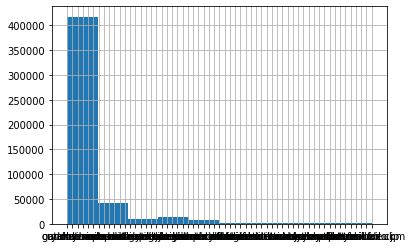

In [182]:
transaction['P_emaildomain'].hist()

Ok so it's clear from this graph that the vast majority of emails are from a few domains.

In [183]:
transaction['P_emaildomain'].value_counts()

gmail.com           228355
yahoo.com           100934
hotmail.com          45250
anonymous.com        36998
aol.com              28289
comcast.net           7888
icloud.com            6267
outlook.com           5096
msn.com               4092
att.net               4033
live.com              3041
sbcglobal.net         2970
verizon.net           2705
ymail.com             2396
bellsouth.net         1909
yahoo.com.mx          1543
me.com                1522
cox.net               1393
optonline.net         1011
charter.net            816
live.com.mx            749
rocketmail.com         664
mail.com               559
earthlink.net          514
gmail                  496
outlook.es             438
mac.com                436
juno.com               322
aim.com                315
hotmail.es             305
roadrunner.com         305
windstream.net         305
hotmail.fr             295
frontier.com           280
embarqmail.com         260
web.de                 240
netzero.com            230
t

Ok so let's just concatenate each domain with <5000 appearances into 'other'.

In [184]:
P_emails = transaction['P_emaildomain'].copy()

criteria = P_emails.value_counts() > 5000

valid_emails = criteria.index[criteria]

P_emails != valid_emails.any()

P_emails[~(P_emails.isin(valid_emails))] = 'other'


In [185]:
P_emails.unique()

array(['other', 'gmail.com', 'outlook.com', 'yahoo.com', 'anonymous.com',
       'hotmail.com', 'aol.com', 'comcast.net', 'icloud.com'],
      dtype=object)

<AxesSubplot:>

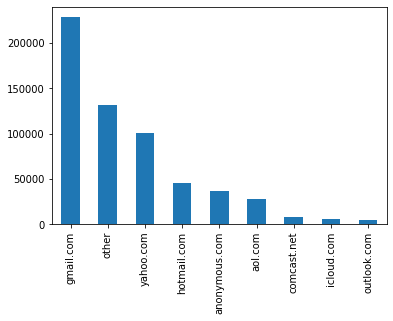

In [186]:
P_emails.value_counts().plot(kind='bar')

Now let's have a quick look at r-emails

In [187]:
R_emails = transaction['R_emaildomain'].copy()

R_emails.value_counts() # seems to be mainly the same emails as before so use the same list as previous.

gmail.com           57147
hotmail.com         27509
anonymous.com       20529
yahoo.com           11842
aol.com              3701
outlook.com          2507
comcast.net          1812
yahoo.com.mx         1508
icloud.com           1398
msn.com               852
live.com              762
live.com.mx           754
verizon.net           620
me.com                556
sbcglobal.net         552
cox.net               459
outlook.es            433
att.net               430
bellsouth.net         422
hotmail.fr            293
hotmail.es            292
web.de                237
mac.com               218
ymail.com             207
prodigy.net.mx        207
optonline.net         187
gmx.de                147
yahoo.fr              137
charter.net           127
mail.com              122
hotmail.co.uk         105
gmail                  95
earthlink.net          79
yahoo.de               75
rocketmail.com         69
embarqmail.com         68
scranton.edu           63
yahoo.es               57
live.fr     

In [188]:
criteria = R_emails.value_counts() > 5000

valid_emails = criteria.index[criteria]

R_emails != valid_emails.any()

R_emails[~(R_emails.isin(valid_emails))] = 'other'

In [189]:
transaction['P_emaildomain'] = P_emails
transaction['R_emaildomain'] = R_emails

/var/folders/qf/ls8tfsdj4dl72c8sdyw287xh0000gn/T/ipykernel_62049/237815104.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transaction['P_emaildomain'] = P_emails
/var/folders/qf/ls8tfsdj4dl72c8sdyw287xh0000gn/T/ipykernel_62049/237815104.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transaction['R_emaildomain'] = R_emails


In [190]:
valid_emails

Index(['gmail.com', 'hotmail.com', 'anonymous.com', 'yahoo.com'], dtype='object')

Now let's take a look at the unique values again.

In [191]:
transaction.select_dtypes('object').nunique() # much more manageable

ProductCD        5
card4            4
card6            4
P_emaildomain    9
R_emaildomain    5
M4               3
dtype: int64

In [192]:
# Let's one-hot encode these values now

encoded_transactions = pd.get_dummies(transaction)

Now let's take a look at the identity dataframe.

In [193]:
identity = train_identity.copy()

In [194]:
identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


Let us again get rid of the columns that are majority null 

In [195]:
identity.isna().sum()/len(identity)

TransactionID    0.000000
id_01            0.000000
id_02            0.023303
id_03            0.540161
id_04            0.540161
id_05            0.051084
id_06            0.051084
id_07            0.964259
id_08            0.964259
id_09            0.480521
id_10            0.480521
id_11            0.022568
id_12            0.000000
id_13            0.117262
id_14            0.445037
id_15            0.022519
id_16            0.103257
id_17            0.033723
id_18            0.687221
id_19            0.034077
id_20            0.034472
id_21            0.964231
id_22            0.964162
id_23            0.964162
id_24            0.967088
id_25            0.964419
id_26            0.964204
id_27            0.964162
id_28            0.022568
id_29            0.022568
id_30            0.462224
id_31            0.027393
id_32            0.462079
id_33            0.491871
id_34            0.460560
id_35            0.022519
id_36            0.022519
id_37            0.022519
id_38       

In [196]:
criteria = identity.isna().sum() / len(identity) > 0.85

identity.drop(criteria.index[criteria], inplace=True, axis=1)

In [197]:
identity.head() # seems like id_35 -38 are true or false, so replace with 1 or 0.

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,100.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,100.0,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,100.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,0.0,0.0,100.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [198]:
identity[['id_35','id_36','id_37','id_38']] = identity[['id_35','id_36','id_37','id_38']].replace(to_replace={'T':1, 'F':0})

In [199]:
identity.select_dtypes('object').nunique()

id_12            2
id_15            3
id_16            2
id_28            2
id_29            2
id_30           75
id_31          130
id_33          260
id_34            4
DeviceType       2
DeviceInfo    1786
dtype: int64

Let's take a closer look at id_30-33 and device info

In [200]:
tricky_ids = identity[['id_30','id_31','id_33','DeviceInfo']]

tricky_ids.head()

,id_30,id_31,id_33,DeviceInfo
0,Android 7.0,samsung browser 6.2,2220x1080,SAMSUNG SM-G892A Build/NRD90M
1,iOS 11.1.2,mobile safari 11.0,1334x750,iOS Device
2,NaN,chrome 62.0,NaN,Windows
3,NaN,chrome 62.0,NaN,NaN
4,Mac OS X 10_11_6,chrome 62.0,1280x800,MacOS


Ok so it looks like id_30 is the os and version, id_31 is the browser, id_33 is the screen dimensions and DeviceInfo is the general OS.
Let us again see if we can do the 'other' trick from before.

In [201]:
criteria = [tricky_ids[col].value_counts() > 0.10 * max(tricky_ids[col].value_counts()) for col in tricky_ids]

criteria

[Windows 10           True
 Windows 7            True
 iOS 11.2.1           True
 iOS 11.1.2           True
 Android 7.0          True
                     ...  
 func                False
 iOS 11.4.0          False
 Mac OS X 10_13_5    False
 Windows             False
 iOS 11.4.1          False
 Name: id_30, Length: 75, dtype: bool,
 chrome 63.0                 True
 mobile safari 11.0          True
 mobile safari generic       True
 ie 11.0 for desktop         True
 safari generic              True
                            ...  
 iron                       False
 LG/K-200                   False
 cyberfox                   False
 Nokia/Lumia                False
 chrome 67.0 for android    False
 Name: id_31, Length: 130, dtype: bool,
 1920x1080     True
 1366x768      True
 1334x750      True
 2208x1242     True
 1440x900      True
              ...  
 1536x960     False
 1232x800     False
 1264x924     False
 1281x800     False
 1280x900     False
 Name: id_33, Length: 260, dty

In [202]:
for col, cr in zip(['id_30','id_31','id_33','DeviceInfo'], criteria):
    valid_types = cr.index[cr]
        
    ser = tricky_ids[col]
    
    ser[~(ser.isin(valid_types))] = 'other'
    
    print(ser.nunique())
    
    tricky_ids.loc[:,col] = ser
    
    
tricky_ids.loc[:,'id_30'].unique()

8
18
15
5


/usr/local/lib/python3.9/site-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.9/site-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


array(['Android 7.0', 'iOS 11.1.2', 'other', 'Mac OS X 10_11_6',
       'Windows 10', 'Mac OS X 10_12_6', 'Windows 7', 'iOS 11.2.1'],
      dtype=object)

In [203]:
identity[['id_30','id_31','id_33','DeviceInfo']] = tricky_ids

Now join the two dbs together

In [204]:
full = transaction.join(identity.set_index('TransactionID'), on='TransactionID')

full.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,other,32.0,other,match_status:2,1.0,0.0,1.0,1.0,mobile,other


In [205]:
#split into numerical and cat

full_numeric = full.select_dtypes(include=np.number)
full_cat = full.select_dtypes(exclude=np.number)
full_cat.loc[:,'isFraud'] = full.loc[:,'isFraud']

full_cat = pd.get_dummies(full_cat)

full.head()

/usr/local/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,other,32.0,other,match_status:2,1.0,0.0,1.0,1.0,mobile,other


In [206]:
corr_num = full_numeric.corr()
corr_cat = full_cat.corr()

In [207]:
corr_num['isFraud'].sort_values

<bound method Series.sort_values of TransactionID     0.014166
isFraud           1.000000
TransactionDT     0.013103
TransactionAmt    0.011320
card1            -0.013640
                    ...   
id_32             0.069702
id_35            -0.143162
id_36            -0.037208
id_37             0.026106
id_38            -0.070577
Name: isFraud, Length: 61, dtype: float64>

In [208]:
corr_cat['isFraud']

isFraud                   1.000000
ProductCD_C               0.161442
ProductCD_H               0.016784
ProductCD_R               0.004030
ProductCD_S               0.018515
                            ...   
DeviceInfo_MacOS         -0.010338
DeviceInfo_Trident/7.0   -0.013577
DeviceInfo_Windows        0.049069
DeviceInfo_iOS Device     0.028057
DeviceInfo_other          0.143823
Name: isFraud, Length: 94, dtype: float64

<AxesSubplot:>

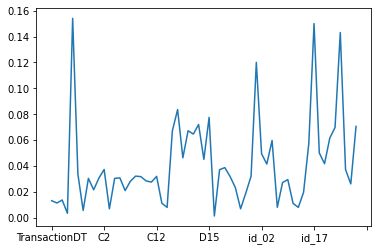

In [209]:
np.abs(corr_num['isFraud'][2:]).plot()

# too many vars

In [210]:
# Find vars of over 0.1

num_vars = np.abs(corr_num['isFraud'][2:]) > 0.1


num_vars[num_vars]


card3    True
id_01    True
id_17    True
id_35    True
Name: isFraud, dtype: bool

<AxesSubplot:>

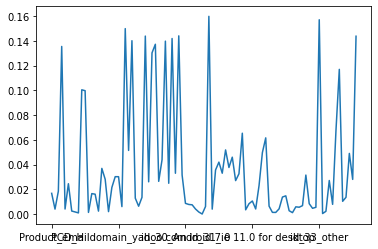

In [211]:
np.abs(corr_cat['isFraud'][2:]).plot()

#possibly remove vars that have < 0.10 corr

In [213]:
train_transaction['addr2'].value_counts()

87.0    520481
60.0      3084
96.0       638
32.0        91
65.0        82
         ...  
49.0         1
14.0         1
25.0         1
22.0         1
93.0         1
Name: addr2, Length: 74, dtype: int64

In [214]:
cat_vars = np.abs(corr_cat['isFraud'][2:]) > 0.1


cat_vars[cat_vars]

ProductCD_W                True
card6_credit               True
R_emaildomain_gmail.com    True
R_emaildomain_other        True
M4_M2                      True
id_12_NotFound             True
id_15_Found                True
id_16_Found                True
id_28_Found                True
id_29_Found                True
id_30_other                True
id_33_other                True
DeviceType_mobile          True
DeviceInfo_other           True
Name: isFraud, dtype: bool